In [14]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import autoreject

ModuleNotFoundError: No module named 'autoreject'

In [5]:
#Takes a period as list of samples, desired segment length in seconds and the sampling frequency, returns a list of segments of the period {{},{},...{}}
def splitperiod(period, segment_length, sampling_freq):
    segments = []
    current_segment = []
    sample_seglen = segment_length * sampling_freq
    for i, sample in enumerate(period):
        current_segment.append(sample)
        if i%sample_seglen == 0 and i!=0:
            segments.append(current_segment)
            current_segment = []
    return segments

def find_cluster(x, xval):
    """
    Find clusters of data in an ndarray that satisfy a certain condition.


    :param x: The array containing the data for the cluster search.
    :type x: ndarray

    :param xval: The value of x that has to be satisfied for clustering.
    :type xval: integer, float


    :returns: 2-tuple

        * i0:
            The index of each cluster starting point.

        * clustersize:
            The corresponding lengths of each cluster.

    :rtype: (list, list)


    Example
    -------
        >>> x = np.int32(np.round(np.random.rand(20)+0.1))
        >>> i0, clustersize = find_cluster(x, 1)

    """
    # Cluster information list
    a = []
    # Initial (place holder) values for cluster start and end points
    kstart = -1
    kend = -1
    # Going through each value of x
    for i, xi in enumerate(x):
        if xi == xval:
            # Assigning cluster starting point
            if kstart == -1:
                kstart = i
            # Assigning cluster end point for particular case
            # when there is an xval in the last position of x
            if i == len(x)-1:
                kend = i
        else:
            # Assigning cluster end point
            if kstart != -1 and kend == -1:
                kend = i-1
        # Updating cluster information list
        # and resetting kstart and kend
        if kstart != -1 and kend != -1:
            a.append(kstart)
            a.append(kend)
            kstart = -1
            kend = -1
    # Assigning indeces of cluster starting points
    # (Every other list element starting from position 0)
    i0 = a[0:-1:2]
    # Assigning cluster sizes
    # (Every other list element starting from position 1)
    clustersize = list(np.array(a[1::2]) - np.array(i0) + 1)
    # Case where cluster size is ZERO
    if len(i0) == 0:
        i0 = []
        clustersize = []
    return i0, clustersize


Extracting EDF parameters from d:\Epilepsi spike detection\Data\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\johan\AppData\Local\Temp\ipykernel_14064\605017845.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()


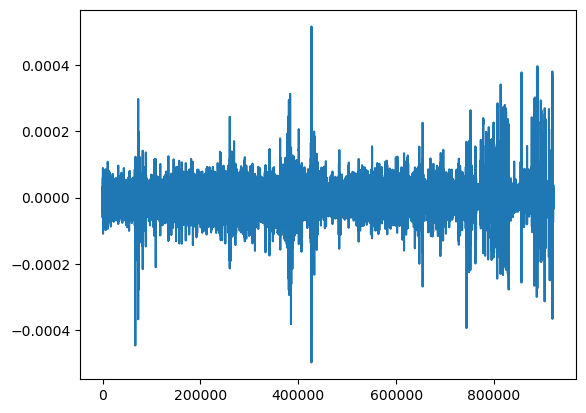

In [28]:
raw_data = mne.io.read_raw_edf('Data/chb01_04.edf').get_data()
plt.plot(raw_data[1])


In [29]:
#EEG processing for Epileptic Predition project
#Author: Michelle von Rosen
#Date: September 2022

#Import packages
import mne
import matplotlib
from autoreject import get_rejection_threshold

######Load data######
p_id = 'chb01_01'
data_dir = 'Data'
file = data_dir + '/' + p_id + '.edf'
raw = mne.io.read_raw_edf('Data/chb01_01.edf', preload=True)

# Set electrode locations
#print(mne.channels.get_builtin_montages())
#montage = mne.channels.make_standard_montage('standard_1020') # Electrode position file 
#raw.set_montage(montage)  # 1020 for International 10-20 system
#montage.plot() #duplicate channes, "-" casuing issues

######Filter data######
low_cut = 1.0
hi_cut = 30
raw_ica = raw.copy().filter(low_cut, hi_cut)
#raw_filt.plot_psd(fmax=100);

######Remove artifacts######
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

#reject one-offs of very noisy data
reject = get_rejection_threshold(epochs_ica);
reject

# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

ica.save(data_dir + '/' + p_id + '-ica.fif', overwrite=True);


Extracting EDF parameters from d:\Epilepsi spike detection\Data\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\johan\AppData\Local\Temp\ipykernel_14064\3660523853.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('Data/chb01_01.edf', preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.1s finished


Not setting metadata
3600 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3600 events and 257 original time points ...
1 bad epochs dropped
Estimating rejection dictionary for eeg
Fitting ICA to data using 23 channels (please be patient, this may take a while)


C:\Users\johan\AppData\Local\Temp\ipykernel_14064\3660523853.py:49: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica,


Selecting by explained variance: 16 components
Fitting ICA took 75.3s.
Overwriting existing file.
Writing ICA solution to d:\Epilepsi spike detection\Data\chb01_01-ica.fif...


RuntimeError: info["meas_date"] seconds must be between "(-2147483648, 0)" and "(2147483647, 0)", got "3371888574"

402
402


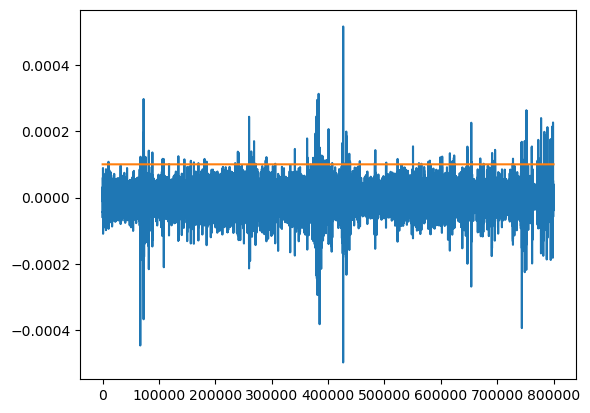

In [10]:
start_time = 0
i = start_time
time_to_plot = 800000
#raw_data_section = []
##while i < start_time+time_to_plot:
 #   raw_data_section.append(raw_data[1][i])
 #   i += 1
j = 0
raw_data_section = np.zeros((time_to_plot))
while i < start_time+time_to_plot:
    raw_data_section[j] = raw_data[1][i]
    i +=1
    j +=1

i = 0

#treshold for the peaks
threshold = 0.0001


plt.plot(raw_data_section)
treshold_plot = threshold*np.ones((time_to_plot), dtype=int)
plt.plot(treshold_plot)
#treshold_plot = np.ones()




i0, clustersize = find_cluster(raw_data_section<threshold, 0)
print(len(i0))
print(len(clustersize))


In [18]:
#picks out the peaks that meet the time criteria 
i0_spikes = []
spike_cluster = []
#print(np.floor(256*0.04))
for i,size in enumerate(clustersize):
    if size > np.floor(256*0.04) and size < np.floor(256*0.07):
        spike_cluster.append(size)
        i0_spikes.append(i0[i])
print(len(i0_spikes))

#print(spike_cluster)

24


In [19]:
#extracts all spikes and stores in list 
AllSpikes = []
for n,spike_start in enumerate(i0_spikes):
    #print(spike_cluster[n])
    #print(spike_start)
    r = []
    i = spike_start
    while i < spike_start + spike_cluster[n]:
        #print(i)
        r.append(raw_data_section[i])
        #plt.plot(r)
        i += 1
    AllSpikes.append(r)
#print(AllSpikes)
sizeOfelement = []
for n in AllSpikes:
    sizeOfelement.append(len(n))


In [20]:
# which is the smalest size of allspikes
#print(sizeOfelement)
MinArray = min(sizeOfelement)
print(MinArray)

11


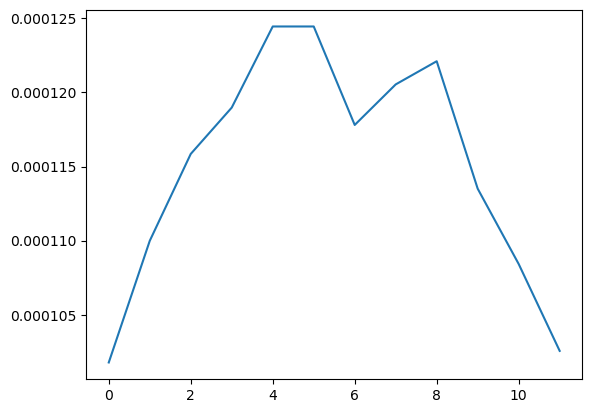

In [21]:
#test to normalise vector lenght
r = AllSpikes[1]
i = np.argmax(r)
#print(i)
biglen = len(r)
#print(biglen)
langd = len(r)
#print(int (i-langd/2))

if ((i+langd/2)-biglen)>0:
    lilaspike = r[int ((i-langd/2)-(i+langd/2-biglen)):biglen]
elif(i-len(r)/2)<0:
    lilaspike = r[0:int ((i+langd/2)-(i-langd/2))]
else:
    lilaspike = r[int (i-langd/2) : int (i+langd/2)]
     
plt.plot(lilaspike)
#print(len(lilaspike))


In [22]:
#Resamplar till kortaste längden 
from scipy import signal
NormalisedLen = []
for r in AllSpikes:
    NewArray = signal.resample(r,MinArray)
    NormalisedLen.append(NewArray)
#print(NormalisedLen)


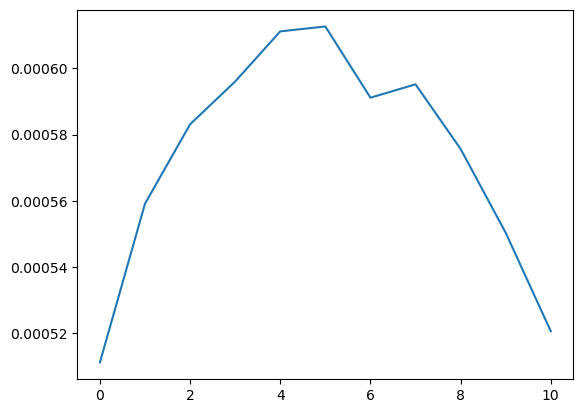

In [23]:
# Mean calculator
#  
minimumIndexCount = len(min(NormalisedLen, key=len))
#print(minimumIndexCount)
MeanSpikes = []
n = 0
while n < minimumIndexCount:
    MeanSpikes.append((NormalisedLen[0][n]+NormalisedLen[1][n]+NormalisedLen[2][n]+NormalisedLen[3][n]+NormalisedLen[4][n]))
    n +=1
#print(MeanSpikes) 

 
#plottar pattern
plt.plot(MeanSpikes) 

#MeanSpikes = []
#for n,value in enumerate(AllSpikes[2]):
#    MeanSpikes.append((AllSpikes[0][n]+AllSpikes[1][n]+AllSpikes[2][n]+AllSpikes[3][n]+AllSpikes[4][n]))
#plt.plot(MeanSpikes) 